In [1]:
import gensim

In [2]:
with open("ceasar.txt",encoding="utf-8") as file:
    l = file.read()

In [3]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
from typing import List
from dataclasses import dataclass, asdict
import uuid
@dataclass
class Paragraph:
    pre_cleaned_words: List[str]
    tags: List[int]
    depth :int = 0
    prev = None
    next_=None
    
#     @property
#     def words(self):
        

In [5]:
import re
def create_corpus(filename):
    with open(filename,encoding="utf-8") as file:
        l = file.read()
    text1 = [i.replace("\n"," ") for i in l.split("\n\n") ]
    text2 = [re.sub(r'\[(.*?)\]',"",i) for i in text1]
    text3 = [
    Paragraph(text.split(" "),[uuid.uuid1().hex]) 
    for index,text in enumerate(text2) 
    if( text != " " and text != "" and text.upper() !=text) 
    ]
    return text3

In [6]:
train_corpus = create_corpus("ceasar.txt")
test_corpus= create_corpus("ceasar_test.txt")

# Clean up text
1. ~Vocab limited to 10_000~
    - normally 60_000 but text only has 14_000 words
    - vocab limited to all words that appear at least twice
2. separate contractions
3. ~lowercase with uppercase markers~
4. ~mark end up sentences and remove periods, commas~
5. padding for beginning sentences

In [10]:
from collections import Counter
vocab = Counter()

In [11]:
for paragraph in train_corpus:
    vocab.update([ word.lower() for word in paragraph.pre_cleaned_words] )       

In [12]:
vocab_len = len(list(vocab.elements()))

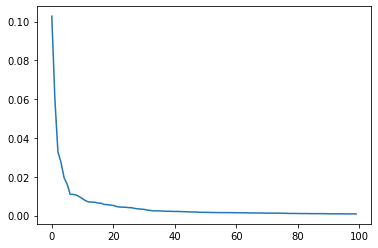

In [13]:
import matplotlib.pyplot as plt

plt.plot([i[1]/vocab_len for i in vocab.most_common(len(vocab))][0:100])

In [14]:
vocab.most_common()[6280]

('enthusiastic', 2)

In [15]:
min_word_counter = Counter(vocab.keys())

In [16]:
vocab = vocab - min_word_counter

In [17]:
vocab.most_common(len(vocab))[-1]

('defends', 1)

In [18]:
def replace_words(word_list):
    new_list = ["xxxbos"]
    for i in word_list:
#         if i[0] == '"':
#             new_list += ["xxxquote"]
        #check if in vocab
        if i in vocab:
            token = i
        else:
            token = "xxxunk"
        if i == i.title():
            new_list += ["xxxcap", token.lower()]
        elif i[-1] == ".":
            new_list += [token[0:-1], ".", "xxxbos"]
        elif i[-1] == ",":
            new_list += [token[0:-1]]
        elif i[-1] == '"':
            new_list += [token[0:-1,"xxxquote"]]
        else:
            new_list +=[i]
    return new_list

In [19]:
cleaned_train_corpus = create_corpus("ceasar.txt")

In [20]:
for paragraph in cleaned_train_corpus:
    paragraph.words = replace_words(paragraph.pre_cleaned_words)

In [21]:
import multiprocessing
from collections import OrderedDict

import gensim.models.doc2vec
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

from gensim.models.doc2vec import Doc2Vec

common_kwargs = dict(
    vector_size=100, epochs=20, min_count=2,
    sample=0, workers=multiprocessing.cpu_count(), negative=5, hs=0,
)

simple_models = [
    # PV-DBOW plain
    Doc2Vec(dm=0, **common_kwargs),
    # PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
    Doc2Vec(dm=1, window=10, alpha=0.05, comment='alpha=0.05', **common_kwargs),
    # PV-DM w/ concatenation - big, slow, experimental mode
    # window=5 (both sides) approximates paper's apparent 10-word total window size
    Doc2Vec(dm=1, dm_concat=1, window=5, **common_kwargs),
]

for model in simple_models:
    model.build_vocab(cleaned_train_corpus)
    print("%s vocabulary scanned & state initialized" % model)

models_by_name = OrderedDict((str(model), model) for model in simple_models)

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
models_by_name['dbow+dmm'] = ConcatenatedDoc2Vec([simple_models[0], simple_models[1]])
models_by_name['dbow+dmc'] = ConcatenatedDoc2Vec([simple_models[0], simple_models[2]])

from random import shuffle
shuffled_corpus = cleaned_train_corpus[:]
shuffle(shuffled_corpus)

for model in simple_models:
    print("Training %s" % model)
    model.train(cleaned_train_corpus, total_examples=len(cleaned_train_corpus), epochs=model.epochs)

for model in [models_by_name['dbow+dmm'], models_by_name['dbow+dmc']]:
    print("\nEvaluating %s" % model)

Doc2Vec(dbow,d100,n5,mc2,t6) vocabulary scanned & state initialized
Doc2Vec("alpha=0.05",dm/m,d100,n5,w10,mc2,t6) vocabulary scanned & state initialized
Doc2Vec(dm/c,d100,n5,w5,mc2,t6) vocabulary scanned & state initialized
Training Doc2Vec(dbow,d100,n5,mc2,t6)
Training Doc2Vec("alpha=0.05",dm/m,d100,n5,w10,mc2,t6)
Training Doc2Vec(dm/c,d100,n5,w5,mc2,t6)

Evaluating Doc2Vec(dbow,d100,n5,mc2,t6)+Doc2Vec("alpha=0.05",dm/m,d100,n5,w10,mc2,t6)

Evaluating Doc2Vec(dbow,d100,n5,mc2,t6)+Doc2Vec(dm/c,d100,n5,w5,mc2,t6)


In [22]:
import sqlite3

conn = sqlite3.connect(":memory:")
cur = conn.cursor()
cur.execute("CREATE TABLE paragraphs(words text, uuid text)")
cur.executemany("INSERT INTO paragraphs VALUES (?,?)", [(" ".join(i.pre_cleaned_words), i.tags[0]) for i in cleaned_train_corpus])


In [23]:
import numpy as np
doc_id = np.random.randint(simple_models[0].docvecs.count)  # Pick random doc; re-run cell for more examples
tag = simple_models[0].docvecs.index_to_doctag(doc_id)
print(f'for doc {doc_id}...{tag}')


print(cur.execute("SELECT * FROM paragraphs WHERE uuid = (?)", (tag,)).fetchone()[0])

for model in simple_models:
    most_similar = model.docvecs.most_similar(model.docvecs.index_to_doctag(doc_id), topn=3)
    for i in most_similar:
        print(i[0],i[1])
    tag = most_similar[1][0]
    print(cur.execute("SELECT * FROM paragraphs WHERE uuid = (?)", (tag,)).fetchone()[0])
    print("\n")

for doc 681...ac9363afc08611eaacc10c9d92106694
We may for the most part consider as Cæsar’s laws those which were passed at his instigation, whether by the tribune P. Vatinius, or the prætor Q. Fufius Calenus.
ac916955c08611ea98790c9d92106694 0.9819753170013428
ac916957c08611eab2f00c9d92106694 0.9770715832710266
ac920530c08611ea849a0c9d92106694 0.972644031047821
_Palace of the Tuileries, March 20th, 1862._


ac918f71c08611eab4d90c9d92106694 0.8567085862159729
ac918f79c08611ea9cc40c9d92106694 0.8223661780357361
ac93639bc08611eaab050c9d92106694 0.8123207092285156
The kings had always sought to put a curb on these usurpations, and perhaps it was a similar attempt which cost Servius Tullius his life. But after the fall of the kingly power, the patricians, having become more powerful, determined to preserve the lands which they had unjustly seized.


ac920550c08611eab6f90c9d92106694 0.9459874629974365
ac916956c08611ea907d0c9d92106694 0.943191409111023
ac922c35c08611eaa4e60c9d92106694 0.9423

In [24]:
for index,j in enumerate(cleaned_train_corpus):
    try:
        j.next_ = cleaned_train_corpus[index+1]    
    except:
        j.next = None
for index,j in enumerate(cleaned_train_corpus[::-1]):
    try:
        j.prev = cleaned_train_corpus[::-1][index+1]    
    except:
        j.prev=None
for i in cleaned_train_corpus:
    i.depth = 0

In [25]:
for index, paragraph in enumerate(cleaned_train_corpus[1:-1],start=1):
    sim_prev = model.docvecs.similarity(paragraph.tags[0], paragraph.prev.tags[0])
    sim_next_ = model.docvecs.similarity(paragraph.tags[0], paragraph.next_.tags[0])

    if sim_prev >= sim_next_:
        paragraph.depth +=1
        paragraph.next_.depth = paragraph.depth
    else:
        search_depth = paragraph.depth
        while search_depth > 0 :
            p1 = paragraph.prev
            p2 = p1.prev
            while p2.depth -1 >= p1.depth:
                p2 = p2.prev
            sim_1 = model.docvecs.similarity(paragraph.tags[0], p1.tags[0])
            sim_2 =  model.docvecs.similarity(paragraph.tags[0], p2.tags[0])
            
            if sim_2 > sim_1:
                search_depth-=1
                
            else:
                paragraph.depth = paragraph.prev.depth
                search_depth =-1


In [26]:
sim_prev, sim_next_

(-0.14529522, 0.16695015)

In [27]:
text = [asdict(i) for i in cleaned_train_corpus]

In [28]:
for i in text:
    i["pre_cleaned_words"] = " ".join(i["pre_cleaned_words"])

In [29]:
import json
with open("srv/static/caesar_part_1.json","w") as f:
    json.dump({"data": text},f)